In [1]:
import ufl
from ufl import dx, ds, grad, TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate,exp

import dolfinx
from dolfinx import mesh, fem, io
from dolfinx.fem import Constant, FunctionSpace,Function, dirichletbc,locate_dofs_geometrical,form
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
from petsc4py.PETSc import ScalarType
import numpy as np
import matplotlib.pyplot as plt


class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


def all_boundary_dofs(domain, space):
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
        )
    boundary_facets = mesh.exterior_facet_indices(domain.topology)
    boundary_dofs = fem.locate_dofs_topological(
        space,
        domain.topology.dim - 1,
        boundary_facets,
        )
    return boundary_dofs


dot = Infix(ufl.inner)


def errors_L(uS, def_uEx):
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain, ('CG', uS.function_space.element.space_dimension)
        )
    uEx = Function(V_err)
    uEx.interpolate(def_uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def expression_ufl(space, ufl_function):

    expr = fem.Expression(ufl_function, space.element.interpolation_points())
    func = fem.Function(space)
    func.interpolate(expr)
    return func


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists):
    """Create graph

    Args:
        fig : 
        lists (list): geometry_x, u_array,axe,title
    """

    def data_construct(geometry, x_array):
        data = np.column_stack((geometry[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        geometry_x, u_array, axe, title = list

        levels = np.linspace(u_array.min(), u_array.max(), 10)
        axe.set_title(title)
        plot = axe.tricontourf(
            *data_construct(geometry_x, u_array), levels=levels
            )
        axe.set_aspect(1)
        fig.colorbar(plot, ax=axe)
    return

In [2]:
# Genereting mesh
import gmsh

gmsh.initialize()
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.05)
gmsh.model.mesh.generate(gdim)
from dolfinx.io import gmshio

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0001483s, CPU 0.000138s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.064376s, CPU 0.064584s)
Info    : 1550 nodes 3099 elements


In [3]:
defc_alpha = 4
defc_betta = 13
defc_R0 = 0.3

In [4]:
V = FunctionSpace(domain, ('Lagrange', 1))
x, y = SpatialCoordinate(domain)


In [5]:
bound_dofs = all_boundary_dofs(domain=domain, space=V)
bcs1 = dirichletbc(V=V, dofs=bound_dofs, value=ScalarType(0))
bcs = [bcs1]

ALPHA = Constant(V, ScalarType(defc_alpha))
BETTA = Constant(V, ScalarType(defc_betta))
R0 = Constant(V, ScalarType(defc_R0))
p = ALPHA * exp(-BETTA**2 * (x**2 + (y - R0)**2))
p = expression_ufl(space=V, ufl_function=p)

u, v = TrialFunction(V), TestFunction(V)

F = (grad(u)|dot|grad(v)) * dx - p*v*dx

In [6]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        },
    )
uS = problem.solve()
# p = expression_ufl(space=FunctionSpace(domain,('CG',5)), ufl_function=p)

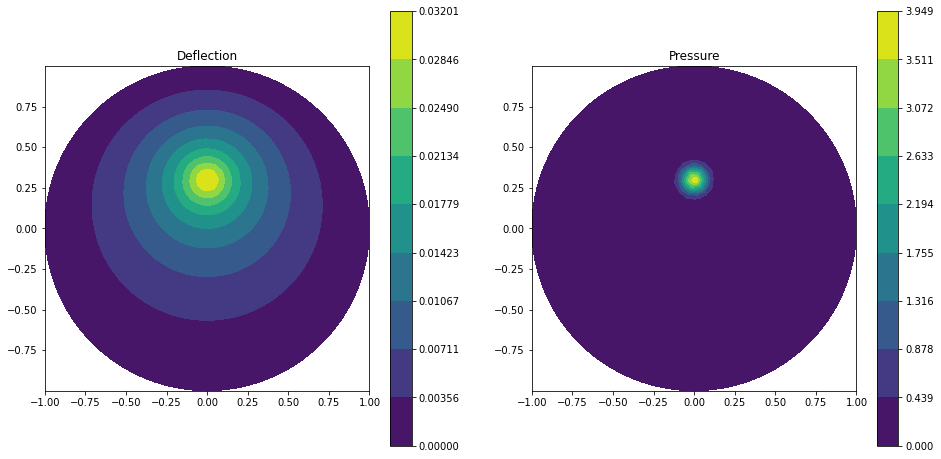

In [7]:
fig, (ax_uS, ax_p) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
lis = [
    [domain.geometry.x, uS.x.array, ax_uS, 'Deflection'],
    [domain.geometry.x, p.x.array, ax_p, 'Pressure']
    ]
graph2D(fig=fig, lists=lis)


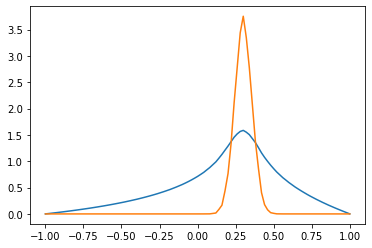

In [8]:
tol = 0.001
y_line = np.linspace(-1 + tol, 1 - tol, 101)
line = np.zeros((3, 101))

line[1] = y_line
collision_line = line_collision(domain=domain, line_cord=line)
uS_online = uS.eval(*collision_line)
p_online = p.eval(*collision_line)

plt.plot(y_line,50*uS_online,)
plt.plot(y_line,p_online,)

In [9]:
with io.VTKFile(domain.comm, '/home/VTK/Deflection_files/Deflection.pvd', 'w') as file:
    uS.name = 'Deflection'
    p.name = 'Pressure'
    file.write_function([uS,p])